In [2]:
# предварительно загрузить kaggle.json в /content

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

kaggle.json
100% 2.37G/2.38G [00:36<00:00, 57.6MB/s]
100% 2.38G/2.38G [00:36<00:00, 69.8MB/s]


In [3]:
!unzip -q /content/makeup-lips-segmentation-28k-samples.zip -d /content/ds

<h1><center>Сегментация изображений</center></h1>

## Часть 2. Подготовка датасета

In [85]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

В названиях картинок и масок заключены индексы, по которым их можно ассоциировать. Создадим пандас.серию названий картинок с индексами, распарсенными из названия. Видно, что картинок 28594.

In [86]:
images_arr = np.array(os.listdir(path="/content/ds/set-lipstick-original/720p"))
img_idx = map(lambda x: int(x[5:-4]), images_arr)
img = pd.Series(images_arr, index=img_idx, name='image').sort_values()
img

1        image00000001.jpg
2        image00000002.jpg
3        image00000003.jpg
4        image00000004.jpg
5        image00000005.jpg
               ...        
28590    image00028590.jpg
28591    image00028591.jpg
28592    image00028592.jpg
28593    image00028593.jpg
28594    image00028594.jpg
Name: image, Length: 28594, dtype: object

Создадим пандас.серию названий масок с индексами, распарсенными из названия. Видно, что масок 28540. 

In [87]:
mask_arr = np.array(os.listdir(path="/content/ds/set-lipstick-original/mask"))
msk_idx = map(lambda x: int(x[4:-4]), mask_arr)
msk = pd.Series(mask_arr, index=msk_idx, name='mask').sort_values()
msk

1        mask00000001.png
2        mask00000002.png
3        mask00000003.png
4        mask00000004.png
5        mask00000005.png
               ...       
28590    mask00028590.png
28591    mask00028591.png
28592    mask00028592.png
28593    mask00028593.png
28594    mask00028594.png
Name: mask, Length: 28540, dtype: object

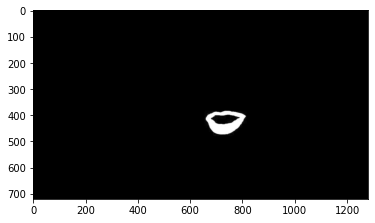

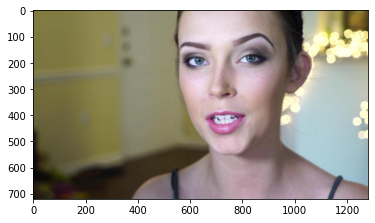

In [88]:
plt.figure()
a = plt.imread("/content/ds/set-lipstick-original/mask/mask00028594.png")
plt.imshow(a.max(axis=2), cmap='gray')
plt.figure()
b = plt.imread("/content/ds/set-lipstick-original/720p/image00028594.jpg")
plt.imshow(b)

Количество масок и картинок различно. Сконкатенируем серии в датафрейм по индексам методом пересечения (inner), чтоб не было пропущенных значений, а индекс сбросим (так как файлы ассоциированны).

In [89]:
df = pd.concat([img,msk], axis=1, join='inner').reset_index(drop=True)
df.isna().any()

image    False
mask     False
dtype: bool

In [90]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch.nn import functional as F
import time

Создадим класс для кастомного датасета:

In [91]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):

        self.img_path = '/content/ds/set-lipstick-original/720p/'
        self.msk_path = '/content/ds/set-lipstick-original/mask/'
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива
        img = plt.imread(self.img_path+self.image_arr[index]).astype('float')
        img = torch.as_tensor(img)/255    
        img = img.unsqueeze(0).permute(0,3,1,2)
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        torch.clamp(img, min=0, max=1)

        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = plt.imread(self.msk_path + self.label_arr[index]).astype('float')
        lab = lab.max(axis=2, keepdims=True)
        lab = torch.as_tensor(lab).permute(2,0,1).unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        return (img.float().squeeze(0), lab.float().squeeze(0))

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки.
И обернем их в наш кастомный класс.

In [92]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

И теперь уже обернем то, что получилось в известные нам в pytorch даталоадеры:

In [93]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


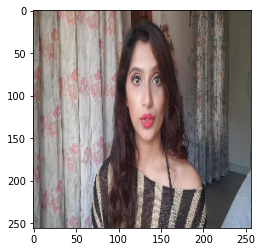

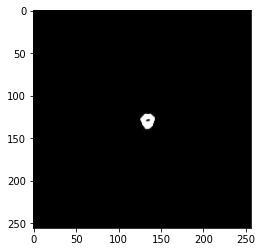

In [94]:
for i,j in train_data_loader:
  img = i
  msk = j
  print(i.size())
  print(j.size())
  break

plt.figure()
plt.imshow(img[0,...].permute(1,2,0).numpy())
plt.figure()
plt.imshow(msk[0,0,...].numpy(),cmap='gray')


## Часть 3. Обучение

Определим количество шагов внутри одной эпохи:

In [97]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

5 epochs, 19978 total_steps per epoch


In [98]:
!pip install segmentation_models_pytorch

In [99]:
import segmentation_models_pytorch as smp

# создание модели
segmodel = smp.Unet('se_resnext50_32x4d',
                    encoder_weights='imagenet',
                    classes=1, activation='sigmoid').to(device)

optimizer = torch.optim.Adam(segmodel.parameters())

loss_f = smp.utils.losses.DiceLoss()

epoch_losses = []

for epoch in range(3):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs)
        loss = loss_f(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


KeyboardInterrupt: ignored

Устал ждать, сделал прерывание обучения. Но результат в итоге хороший!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


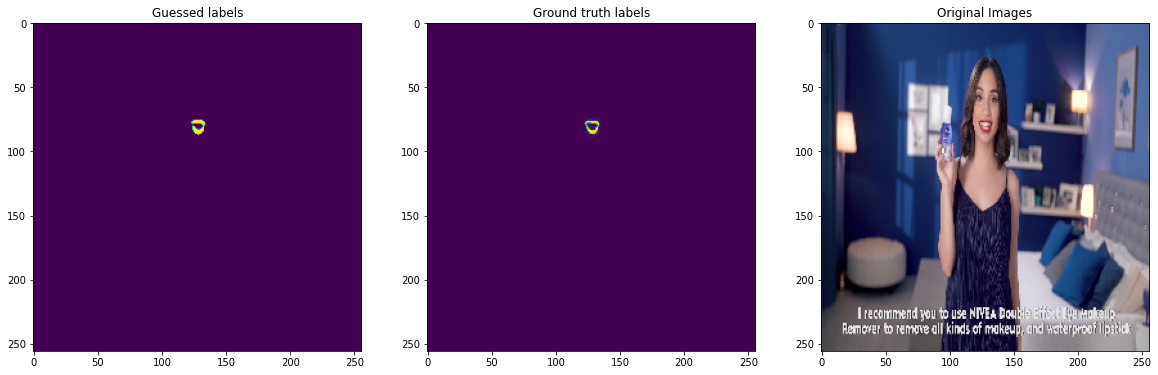

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


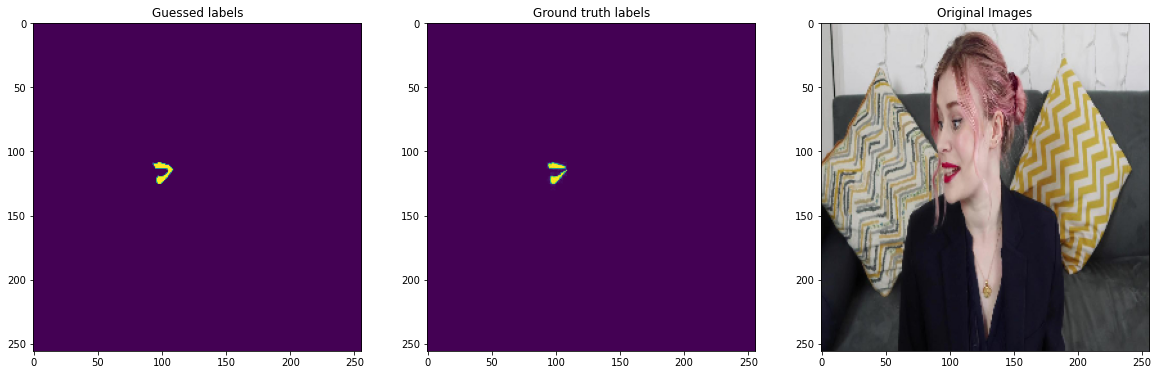

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


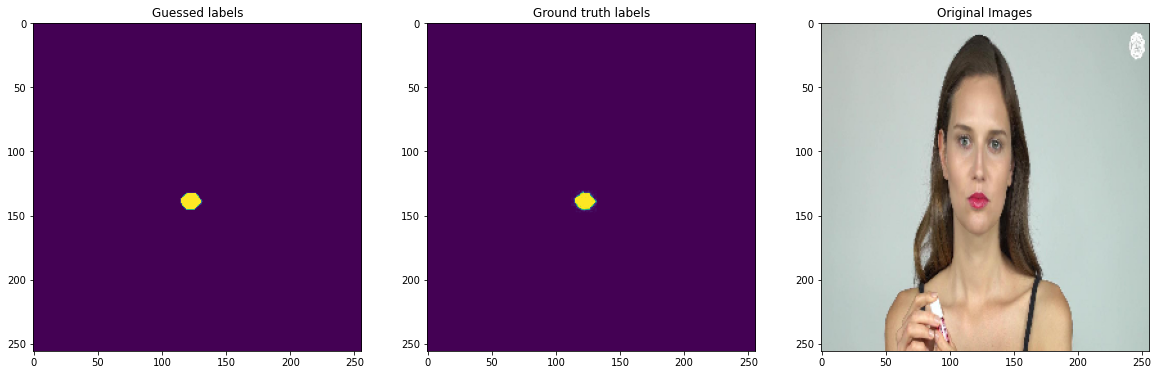

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


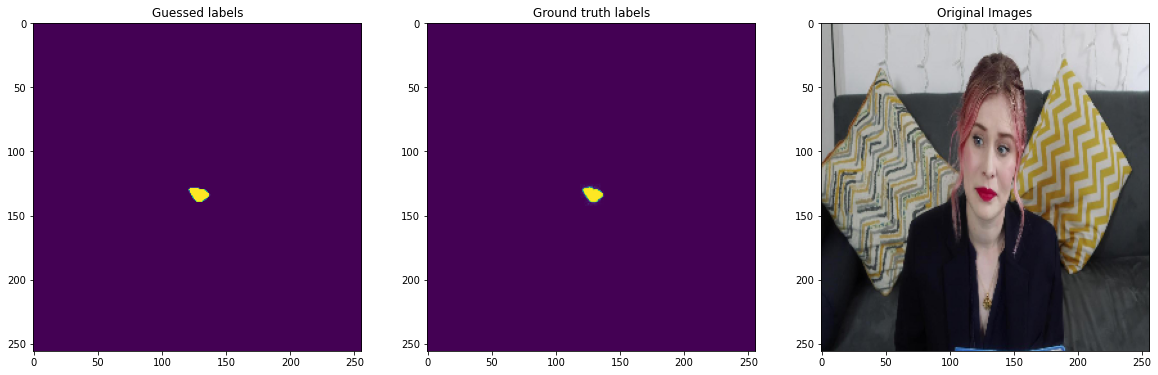

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


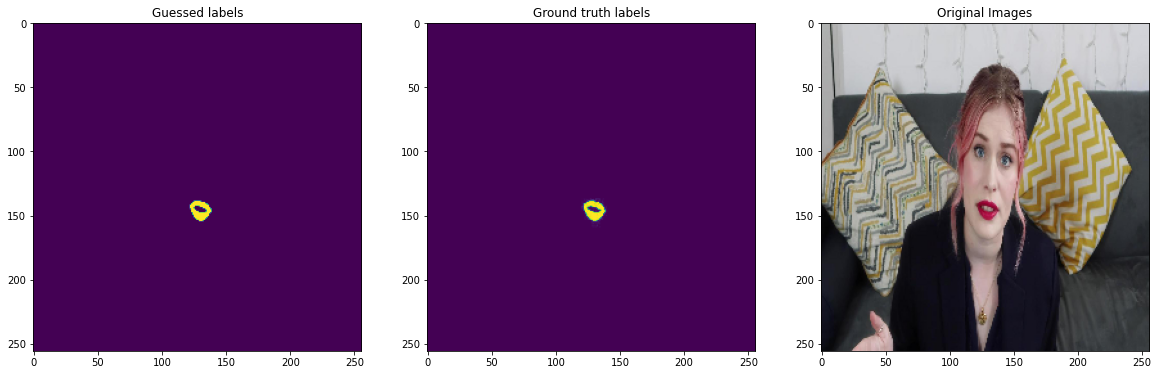

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


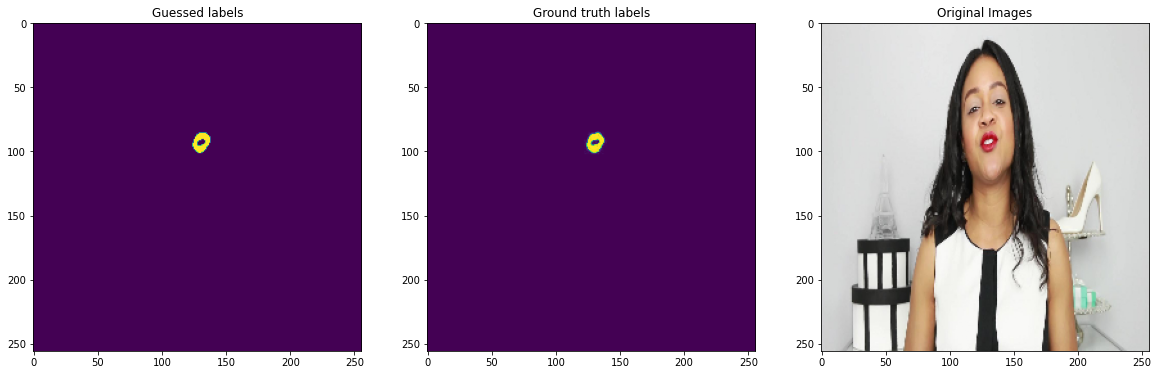

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


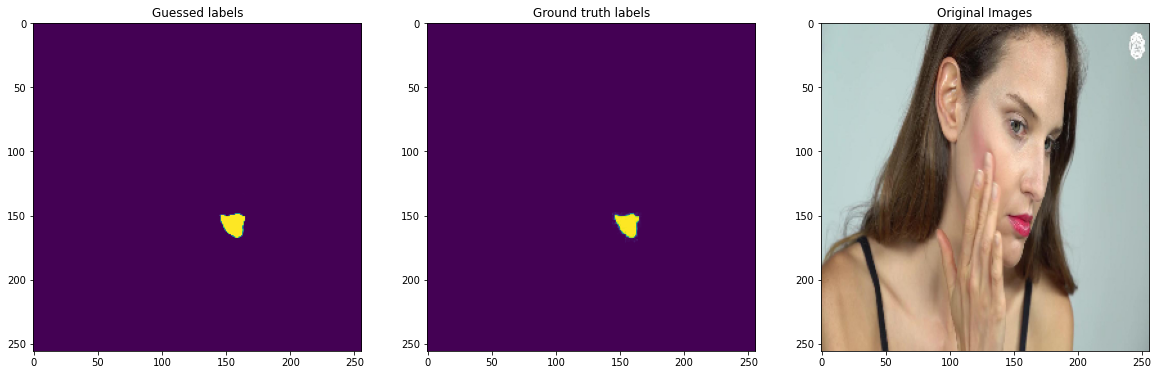

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


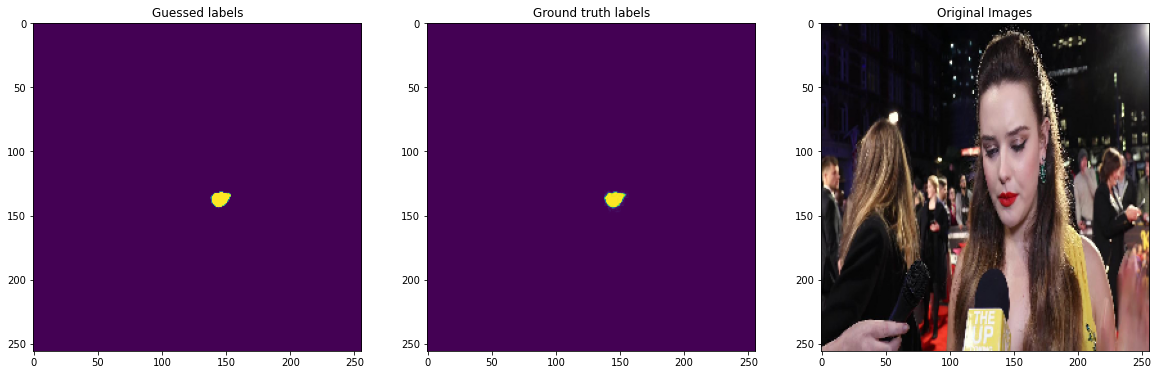

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


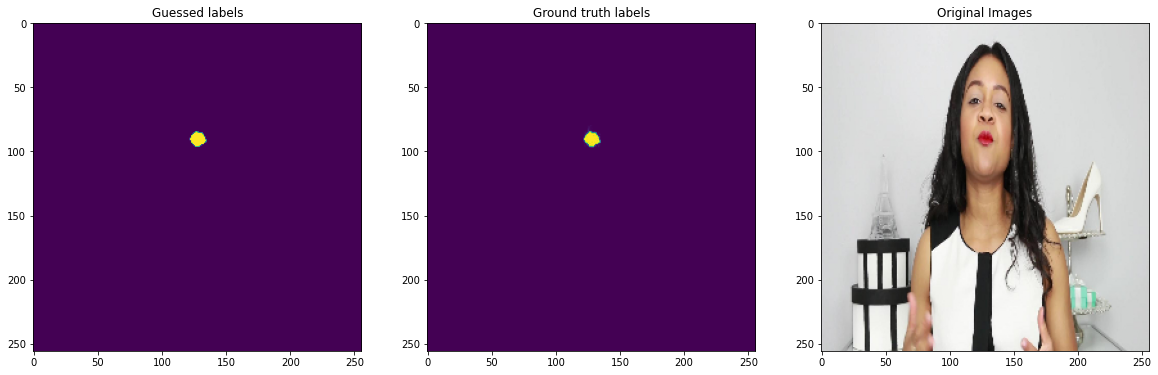

In [107]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3, figsize=(20, 10))

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[0,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().permute(1,2,0).numpy()[:,:,:])
    axarr[2].set_title('Original Images')
    plt.show()

    if i>7:
        break